This notebook illustrates a helper function that transforms the shear components
from one coordinate system to one that is rotated.

In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# Set a cosmological model
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
cosmology.setDefaultCosmology(cosm)

In [4]:
# We'll just use an NSIE lens, aligned with the coordinate axes in one frame
z_lens = 0.4
z_s = 2.0

Dd = cosm.getAngularDiameterDistance(z_lens)
Dds = cosm.getAngularDiameterDistance(z_lens, z_s)
Ds = cosm.getAngularDiameterDistance(z_s)

l = lenses.NSIELens(Dd, { "velocityDispersion": 400000, "coreRadius": 1*ANGLE_ARCSEC, "ellipticity": 0.5})
li = plotutil.LensInfo(l, size=16*ANGLE_ARCSEC, zd=z_lens, zs=z_s)

In [5]:
# To simulate a second frame, we'll rotate this lens and move it somewhat
rotAngleDeg = 30
rotAngle = rotAngleDeg/180*np.pi
x0 = 3*ANGLE_ARCSEC
y0 = 1*ANGLE_ARCSEC

l2 = lenses.CompositeLens(Dd, [{
        "factor": 1, "x": x0, "y": y0, "angle": rotAngleDeg, "lens": l
    }])

li2 = plotutil.LensInfo(l2, size=16*ANGLE_ARCSEC, zd=z_lens, zs=z_s)

In [6]:
# We're going to take shear measurements according to a regular grid
thetas = util.createThetaGrid(-V(7,7)*ANGLE_ARCSEC, V(7,7)*ANGLE_ARCSEC, 20, 20)

In [7]:
# Here, we'll rotate these positions as well, so that relative to the lens and
# its orientation, it describes the same points

rotMatrix = np.array([
    [ np.cos(rotAngle), -np.sin(rotAngle)],
    [ np.sin(rotAngle), np.cos(rotAngle)]
])

thetas2 = np.matmul(rotMatrix, thetas.reshape((-1,2)).T).T.reshape(thetas.shape)
thetas2[:,:,0] += x0
thetas2[:,:,1] += y0

Text(value='')

FloatProgress(value=0.0)

Text(value='')

FloatProgress(value=0.0)

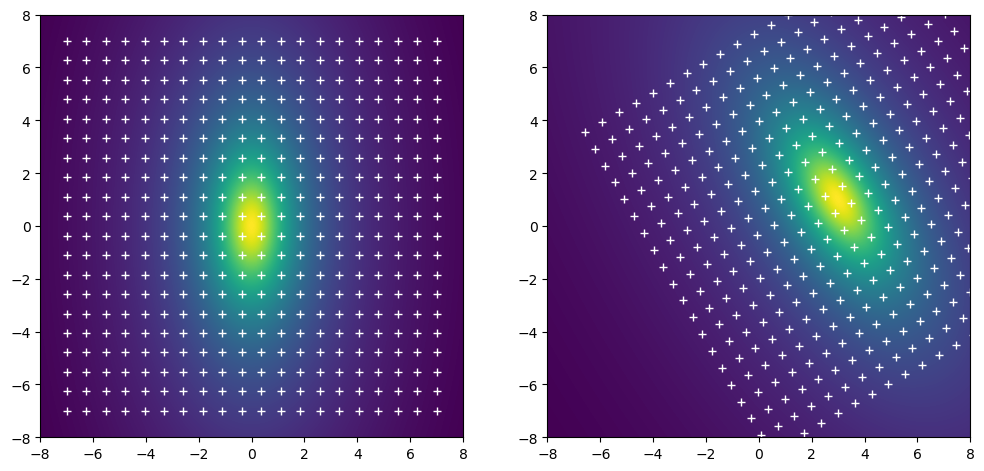

In [8]:
# The plots illustrate this: in the frame on the left, the positions are nicely
# aligned with the coordinate axes. In the second one the coordinates are certainly
# different, but relative to the lens' location and orientation they actually describe
# the same points.
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plotutil.plotDensity(li)
plt.plot(thetas[:,:,0]/ANGLE_ARCSEC, thetas[:,:,1]/ANGLE_ARCSEC, '+', color="white")
plt.subplot(1,2,2)
plotutil.plotDensity(li2)
plt.plot(thetas2[:,:,0]/ANGLE_ARCSEC, thetas2[:,:,1]/ANGLE_ARCSEC, '+', color="white");

In [9]:
# Let's calculate the kappa and gamma values for the two situations
aDerivs = l.getAlphaVectorDerivatives(thetas)
axx, ayy, axy = aDerivs[:,:,0], aDerivs[:,:,1], aDerivs[:,:,2]
axx *= Dds/Ds
ayy *= Dds/Ds
axy *= Dds/Ds
kappa = 0.5*(axx+ayy)
gamma1 = 0.5*(axx-ayy)
gamma2 = axy

aDerivs2 = l2.getAlphaVectorDerivatives(thetas2)
axx2, ayy2, axy2 = aDerivs2[:,:,0], aDerivs2[:,:,1], aDerivs2[:,:,2]
axx2 *= Dds/Ds
ayy2 *= Dds/Ds
axy2 *= Dds/Ds
kappa_2 = 0.5*(axx2+ayy2)
gamma1_2 = 0.5*(axx2-ayy2)
gamma2_2 = axy2

In [10]:
# For the kappa values, the scaled mass densities, you can see that they are indeed
# the same in the two cases (up to some numerical precision), as expected
np.min(kappa - kappa_2), np.max(kappa - kappa_2)

(-3.3306690738754696e-16, 3.3306690738754696e-16)

In [11]:
# For the two gamma values this is not the case however
np.min(gamma1 - gamma1_2), np.max(gamma1 - gamma1_2)

(-0.12791897487680332, 0.2556554370851777)

In [12]:
np.min(gamma2 - gamma2_2), np.max(gamma2 - gamma2_2)

(-0.349294977541571, 0.10369389552927352)

In [13]:
# These gamma values belong together, similar to the components of a vector, and
# if we want to express the same shear in the two frames, we won't have the same
# values of the components

In [14]:
# In practice, shear measurements could be made in one frame, e.g. corresponding to
# the pixels of a camera, but perhaps we'd like to have the components in another
# frame. In this example, we start from the shear values based on the non-rotated
# system, but we'd like to know what they are in the rotated system.
#
# This is straightforward if the rotation angle is known, the function below figures
# out this rotation angle from the two sets of positions, and applies the rotation
# to the shear components.
adjustedGamma1, adjustedGamma2, angle = util.adjustShearMeasurements(thetas, gamma1, gamma2, thetas2, tol=1e-10)
print("Found rotation of", angle/np.pi*180, "degrees from first frame to second frame")

Found rotation of 29.999999999121215 degrees from first frame to second frame


In [15]:
# So now, the adjusted gamma components should equal the ones we measured directly
# on that frame
np.min(adjustedGamma1-gamma1_2),np.max(adjustedGamma1-gamma1_2)

(-3.1808514155962087e-12, 1.0714679143930539e-11)

In [16]:
np.min(adjustedGamma2-gamma2_2),np.max(adjustedGamma2-gamma2_2)

(-7.842296256832526e-12, 3.9239583804473455e-12)